Epoch 1/100


/Users/jainigandhi/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 72.4512 - mae: 4.6045 - val_loss: 59.6776 - val_mae: 4.8338
Epoch 2/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 61.2080 - mae: 4.9916 - val_loss: 59.1139 - val_mae: 5.0984
Epoch 3/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 66.7438 - mae: 5.3052 - val_loss: 58.6203 - val_mae: 4.9254
Epoch 4/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 59.4103 - mae: 5.0524 - val_loss: 58.5383 - val_mae: 4.6932
Epoch 5/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 59.8393 - mae: 5.0493 - val_loss: 58.4513 - val_mae: 4.7378
Epoch 6/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - loss: 59.9096 - mae: 5.0497 - val_loss: 58.3695 - val_mae: 5.0162
Epoch 7/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 58.5301 - mae: 4.9775 - val_loss: 58.5243 - val_mae: 5.1208
Epoch 8/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - loss: 59.8672 - mae: 5.0956 - val_loss: 58.3984 - val_mae: 5.0443
Epoch 9/100
193/193 ━━━━━━━━━━━━

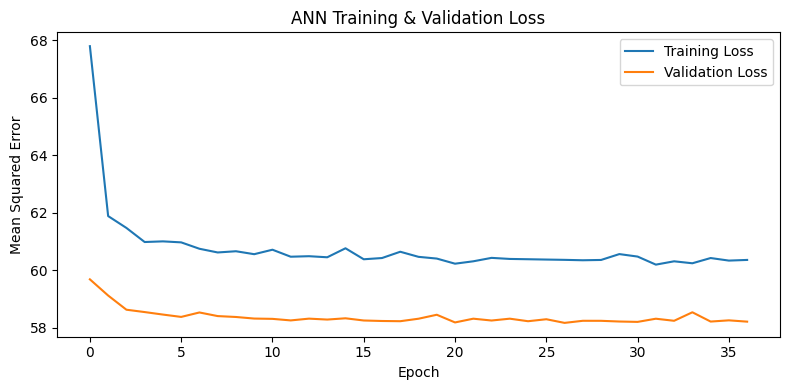

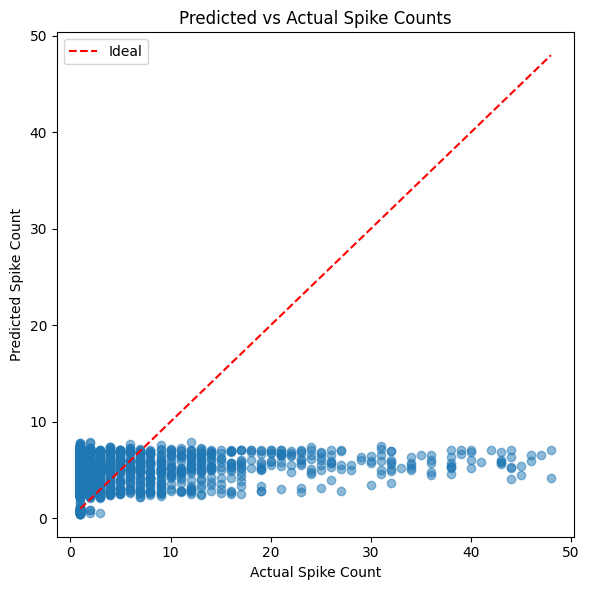

In [32]:
#Imports and Setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score

#Load your dataset
df = pd.read_csv("spikecount_dataset.csv")

#Add engineered features
df = df[df['spike_count'] > 0]  
df = df[df['spike_count'] < 50]

#Log-transformed target
df["log_spike_count"] = np.log1p(df["spike_count"])

df["stim_amp_scaled"] = df["stim_mean"] / 1e12 
df["stim_amp_squared"] = df["stim_amp_scaled"] ** 2

features = ["stim_mean", "stim_max", "stim_min", "stim_std", "stim_integral",
    "stim_duration", "stim_rise_time", "baseline_vstd"]

X = df[features].values
y = df["log_spike_count"].values

#Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

#Build ANN
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

#Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=100, batch_size=32, verbose=1, callbacks=[early_stop])

# Predict and evaluate
y_pred = model.predict(X_test).flatten()
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.2f}")
print(f"R2 Score: {r2:.4f}")

#Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.title("ANN Training & Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

#Plot prediction vs actual
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
plt.xlabel("Actual Spike Count")
plt.ylabel("Predicted Spike Count")
plt.title("Predicted vs Actual Spike Counts")
plt.legend()
plt.tight_layout()
plt.show()